<a href="https://colab.research.google.com/github/VictoriaXinyi/Twitter/blob/main/LDA_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim
!pip install pyLDAvis
!pip install contractions

     |████████████████████████████████| 24.0 MB 80 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7 MB 10.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 186 kB/s 
     |████████████████████████████████| 11.3 MB 33.3 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=6e1e4b0fc3f8e57600ec510137941808e8a04f6ce26d2c2bc7ef4c5127261386
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  

     |████████████████████████████████| 283 kB 7.6 MB/s 
     |████████████████████████████████| 321 kB 50.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85448 sha256=4c3384de3522ed75172a8a314302fab92d229678d08249f57e49a49564d1e6e4
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
from google.colab import drive  # to mount Google Drive to Colab notebook
#import tweepy                   # Python wrapper around Twitter API
import json, csv, re, os, string, nltk, spacy, gensim, requests, time
import contractions
import pandas as pd
from datetime import date
from datetime import datetime
import numpy as np
from numpy import array
from collections import Counter
from operator import itemgetter
from pprint import pprint

# Nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("words") 
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer,TweetTokenizer
stopwords = set(stopwords.words("english"))

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

# Gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
drive.mount('/content/gdrive')
path = './gdrive/My Drive'

Mounted at /content/gdrive


In [ ]:
newdata=pd.read_csv('gdrive/My Drive/newdata.csv')

In [ ]:
# work on a copy data frame
nmfdata = newdata.copy()

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['5g','blacklivesmatter','pizza',
                   'iphone','covid','corona','police','bitcoin', 'soccer',
                   'kobe','photography','biden','music','mars','lgbt',
                   'cat','tiktok','pubg','animation','wallstreet','weather',
                   'is','am','are','be', 'to','from','subject','re','edu',
                   'see','say','not','would','could','look','seem',
                   'come','go','get','do','done','bring','take',
                   'today','yesterday','tomorrow','time','year','month','day',
                   'some','many','little','less','more','most','than',
                   'also'])

In [ ]:
"""
#############################  ========   data prep for NMF  ============ ################################
# List of punctuation
punc = list(set(string.punctuation))

# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens
def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    #text = [expandContractions(each, c_re=c_re) for each in text]
    #text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 3]
    text = [each for each in text if ' ' not in each]
    return text
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1] 
def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)
def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens
# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist
def word_count(text):
    return len(str(text).split(' '))
"""

In [ ]:
# nmfdata.head(2)

,Unnamed: 0,text,clean_tweet,Origin_NO
0,19810,stop killing/harming black people #jacobblake...,stop killing harming black people,19810
1,12111,join @sistersuncut in support of @sistah_spac...,join support protest eviction premises hackney...,12111


In [ ]:
nmfdata['column_name']=nmfdata['clean_tweet'].apply(str)

In [ ]:
#nmfdata['column_name']=nmfdata['clean_tweet'].apply(str)
# Process the text
nmfdata['processed_text'] = nmfdata['column_name'].apply(process_text)
#nmfdata.head(2)

In [ ]:
# ===================== LDA =========================#

In [ ]:
cleandata =nmfdata.copy()
# remove emoji, set contract
cleandata['text'] = cleandata['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

cleandata['no_contract'] = cleandata['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])

cleandata['text_str'] = [' '.join(map(str, l)) for l in cleandata['no_contract']]

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    '''# ####3 #############3 ##############3 ###########3'''
    tweet = re.sub(r'\d+', '', tweet) #removes the digits
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    # tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove hashtag
    return tweet

my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    #tweet = re.sub('([0,1,2,3,4,6,7,8,9]+)', '', tweet) # remove numbers, except "5"
    #tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
   
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in stop_words] # remove stopwords
    #tweet_token_list = [word_rooter(word) if '#' not in word else word for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: Dep

In [ ]:
# Tokenize and Clean-up using gensim’s simple_preprocess()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(newdata.clean_tweet))
print(data_words[:1])

[['stop', 'killing', 'harming', 'black', 'people']]


In [ ]:
cleandata['clean_tweet'] = cleandata.text_str.apply(clean_tweet)
cleandata.head(2)

,Unnamed: 0,text,clean_tweet,Origin_NO,no_contract,text_str
0,19810,stop killing/harming black people #jacobblake...,stop killing harming black people,19810,"[stop, killing/harming, black, people, #jacobb...",stop killing/harming black people #jacobblake ...
1,12111,join @sistersuncut in support of @sistah_spac...,join support protest eviction premises hackney...,12111,"[join, @sistersuncut, in, support, of, @sistah...",join @sistersuncut in support of @sistah_space...


In [ ]:
newdata = cleandata.copy()
newdata = newdata[["text",'clean_tweet']]
newdata.head(3)

,text,clean_tweet
0,stop killing/harming black people #jacobblake...,stop killing harming black people
1,join @sistersuncut in support of @sistah_spac...,join support protest eviction premises hackney...
2,#blacklivesmatter: milwaukee bucks boycott gam...,milwaukee bucks boycott game nba playoff seri...


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
data_words = list(sent_to_words(newdata.clean_tweet))

In [ ]:
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#'

#data_words = list(sent_to_words(newdata.clean_tweet))
#print(data_words[:1])

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    ## Remove numbers, but not words that contain numbers.
    texts_out = [[word for word in simple_preprocess(str(doc)) if not word.isdigit()] for doc in texts_out]   
    ## Remove words that are only one character.
    texts_out = [[word for word in simple_preprocess(str(doc)) if len(word) > 3] for doc in texts_out]
    return texts_out
data_ready = process_words(data_words)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

In [ ]:
print(data_ready[:3])

[['stop', 'kill', 'harm', 'black', 'people'], ['join', 'support', 'protest', 'eviction'], ['shooting']]


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [ ]:
"""
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,
               iterations=20,alpha='auto',eta='auto',eval_every = None,
               passes=50,
               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# check Coherence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=data_ready, start=10, limit=61, step=1)
"""                                                     

"\ndef compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=1):\n    coherence_values = []\n    model_list = []\n    for num_topics in range(start, limit, step):\n        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,\n               iterations=20,alpha='auto',eta='auto',eval_every = None,\n               passes=50,\n               per_word_topics=True)\n        model_list.append(model)\n        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')\n        coherence_values.append(coherencemodel.get_coherence())\n    return model_list, coherence_values\n# check Coherence\nmodel_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, \n                                                        texts=data_ready, start=10, limit=61, step=1)\n"

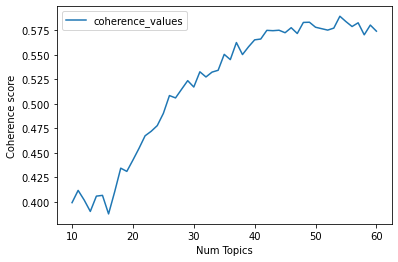

In [ ]:
# Show graph
limit=61; start=10; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["coherence_values"], loc='best')
plt.show()

In [ ]:
"""
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print(m, round(cv, 4))
"""

'\n# Print the coherence scores\nfor m, cv in zip(x, coherence_values):\n    print(m, round(cv, 4))\n'

In [ ]:
# sklearn : LatentDirichletAllocation

In [ ]:
#texts = nmfdata['processed_text']
"""
# Create the tfidf weights
tfidf_vectorizer_lda = TfidfVectorizer(
    min_df=3, 
    max_df=0.85,
    max_features=5691,
    ngram_range=(1, 3),
    preprocessor=' '.join
)

tfidf_lda = tfidf_vectorizer_lda.fit_transform(texts)
"""

In [ ]:
"""
# Optimal number of topics # still 54
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

count_para_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(newdata["clean_tweet"])

from tqdm.auto import tqdm
lda_para_model_n = []
for n in tqdm(range(10, 61)):
    lda_model = LatentDirichletAllocation(n_components = n, random_state=100)
    lda_model.fit_transform(count_para_vectors)
    lda_perplexity = lda_model.perplexity(tfidf_lda)
    lda_para_model_n.append((lda_model, lda_perplexity))
lda_para_model_n
"""

'\n# Optimal number of topics # 54?\nfrom sklearn.decomposition import LatentDirichletAllocation\nfrom sklearn.feature_extraction.text import CountVectorizer\n\ncount_para_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)\ncount_para_vectors = count_para_vectorizer.fit_transform(newdata["clean_tweet"])\n\nfrom tqdm.auto import tqdm\nlda_para_model_n = []\nfor n in tqdm(range(10, 61)):\n    lda_model = LatentDirichletAllocation(n_components = n, random_state=100)\n    lda_model.fit_transform(count_para_vectors)\n    lda_perplexity = lda_model.perplexity(tfidf_lda)\n    lda_para_model_n.append((lda_model, lda_perplexity))\nlda_para_model_n\n'

In [ ]:
num_topics = 54 # 54 is optimal according to coherence
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics = num_topics, random_state=100,
               iterations=20,alpha='auto',eta='auto',
               passes=50,
               per_word_topics=True)  
#lda_model.show_topics(54, num_words=15, formatted=False)

In [ ]:
#pprint(lda_model.print_topics(54))

In [ ]:
pyLDAvis.enable_notebook()
p_54 = gensimvis.prepare(lda_model, corpus, id2word)
p_54

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
34    -0.170557 -0.376218       1        1  3.385477
17    -0.146023  0.044110       2        1  3.306011
18    -0.159566  0.216639       3        1  3.150662
20    -0.121162  0.017491       4        1  3.051094
25    -0.143292  0.037792       5        1  2.938024
11    -0.115410  0.085633       6        1  2.869015
32    -0.092137  0.008587       7        1  2.679350
42    -0.067327  0.004457       8        1  2.574545
31    -0.068519  0.004755       9        1  2.537846
14    -0.070531  0.004838      10        1  2.465190
43    -0.088259  0.007527      11        1  2.417599
49    -0.035941  0.001705      12        1  2.264679
16    -0.038754  0.001905      13        1  2.241761
39    -0.027162  0.001152      14        1  2.149554
44    -0.021487  0.000835      15        1  2.145648
8     -0.012561  0.000163      16        1  2.119564
47    -0.008756  0.000209      17        1  2.099071
15    -0.006530  0.000100      18        1  2.036853
33    -0.014343  0.000464      19        1  2.029331
4     -0.032358  0.001478      20        1  2.009266
10    -0.003954  0.000013      21        1  1.979019
22     0.003547 -0.000322      22        1  1.929268
30    -0.004518  0.000599      23        1  1.887023
48     0.000292 -0.000170      24        1  1.838085
23     0.008941 -0.000617      25        1  1.822829
21     0.009803 -0.000552      26        1  1.735139
40     0.009774 -0.000539      27        1  1.686539
53     0.027031 -0.018125      28        1  1.675593
12     0.018419 -0.000822      29        1  1.675491
50     0.030155 -0.001319      30        1  1.653090
26     0.018534 -0.000831      31        1  1.605676
36     0.030637 -0.001193      32        1  1.582338
7      0.040796 -0.001520      33        1  1.529566
29     0.031324 -0.001213      34        1  1.491631
5      0.042440 -0.001485      35        1  1.485565
38     0.034900 -0.001299      36        1  1.461609
13     0.057448 -0.001993      37        1  1.448463
45     0.052081 -0.001716      38        1  1.443783
35     0.046401 -0.001584      39        1  1.442147
19     0.050451 -0.001682      40        1  1.430922
0      0.042239 -0.001489      41        1  1.396163
9      0.056392 -0.001862      42        1  1.381327
52     0.051655 -0.000905      43        1  1.352230
3      0.054554 -0.001868      44        1  1.350273
2      0.052725 -0.001747      45        1  1.345622
24     0.061371 -0.001903      46        1  1.311180
27     0.063451 -0.001949      47        1  1.248191
1      0.071221 -0.002085      48        1  1.164727
41     0.073566 -0.002233      49        1  1.141418
46     0.069556 -0.002060      50        1  1.139794
6      0.072651 -0.002118      51        1  1.139489
28     0.078495 -0.002208      52        1  1.041397
51     0.091991 -0.002385      53        1  0.884326
37     0.096308 -0.002439      54        1  0.829544, topic_info=               Term         Freq        Total Category  logprob  loglift
71             make  1245.000000  1245.000000  Default  30.0000  30.0000
3            people  1124.000000  1124.000000  Default  29.0000  29.0000
221           video   968.000000   968.000000  Default  28.0000  28.0000
203            good   949.000000   949.000000  Default  27.0000  27.0000
433           check   793.000000   793.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
1986         rioter     4.453901     5.610786  Topic54  -5.2563   4.5611
18    approximately     4.302064     5.458950  Topic54  -5.2910   4.5539
1988       slightly     4.194484     5.351369  Topic54  -5.3163   4.5485
2611         google     3.413028     4.569914  Topic54  -5.5225   4.5002
1456    institution     3.397887     4.554773  Topic54  -5.5270   4.4990

[1675 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
456    

In [ ]:
# What is the Dominant topic and its percentage contribution in each document?

#def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_words):
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
#df_topic_sents_keywords

In [ ]:
# Format df_topic_sents_keywords
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 
                             'Topic_Perc_Contrib', 'Keywords', 'Text']

In [ ]:
#df_dominant_topic

In [ ]:
# Find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
#sent_topics_sorteddf_mallet

In [ ]:
sent_topics_sorteddf_mallet.drop(['Text'],axis =1)

,Topic_Num,Topic_Perc_Contrib,Keywords
0,0.0,0.4371,"place, different, area, link, fire, camera, le..."
1,1.0,0.4452,"pick, strong, date, water, possible, road, lis..."
2,2.0,0.5194,"young, view, online, medium, probably, screen,..."
3,3.0,0.5195,"already, current, sound, thought, base, episod..."
4,4.0,0.4292,"play, tonight, beautiful, picture, miss, crazy..."
5,5.0,0.4866,"much, free, face, mobile, heart, grow, tweet, ..."
6,6.0,0.3882,"post, human, control, entire, star, excellent,..."
7,7.0,0.3900,"right, side, drive, club, movement, sometimes,..."
8,8.0,0.3761,"call, person, order, learn, public, save, forc..."
9,9.0,0.4258,"black, shop, energy, currently, deliver, digit..."


In [ ]:
d1=newdata.join(df_dominant_topic, how="outer")
d1.head(2)

,text,clean_tweet,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,stop killing/harming black people #jacobblake...,stop killing harming black people,0,31.0,0.1858,"people, always, white, racist, honestly, adult...","[stop, kill, harm, black, people]"
1,join @sistersuncut in support of @sistah_spac...,join support protest eviction premises hackney...,1,14.0,0.1216,"thank, week, join, wait, sport, half, characte...","[join, support, protest, eviction]"


In [ ]:
testdata = d1.drop(['Document_No','Topic_Perc_Contrib','Keywords','Text'],axis=1)
testdata.head(2)

,text,clean_tweet,Dominant_Topic
0,stop killing/harming black people #jacobblake...,stop killing harming black people,31.0
1,join @sistersuncut in support of @sistah_spac...,join support protest eviction premises hackney...,14.0


In [ ]:
def find_hashtags(text):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', text)   

testdata['Hashtags'] = testdata.text.apply(find_hashtags)
testdata.head(2)

,text,clean_tweet,Dominant_Topic,Hashtags
0,stop killing/harming black people #jacobblake...,stop killing harming black people,31.0,"[#jacobblake, #blacklivesmatter, #enoughisenou..."
1,join @sistersuncut in support of @sistah_spac...,join support protest eviction premises hackney...,14.0,[#blacklivesmatter]


In [ ]:
# keep hashtag that appear top 10 #80
from collections import Counter

counts = testdata.Hashtags.map(Counter).sum().most_common(80)
top_hashtags = [ht for ht, _ in counts]
hashtags = testdata.Hashtags.map(set)
base_cols = ['Dominant_Topic', 'Hashtags']
matrix = pd.concat(
             [testdata[base_cols]] +
             [
                 hashtags.map(lambda hts: ht in hts).astype(int)
                 for ht in top_hashtags
             ],
             axis='columns'
         )
matrix.columns = base_cols + top_hashtags
# drop the hashtags column
hashtag_matrix= matrix.drop('Hashtags', axis=1)
hashtag_matrix.head(3)

,Dominant_Topic,#blacklivesmatter,#photography,#bitcoin,#tiktok,#lgbt,#pubg,#animation,#weather,#wallstreet,#pdx911,#love,#art,#gay,#lgbtq,#music,#blm,#photooftheday,#soccer,#covid19,#sipgrab,#unitingpeoplewiththepossibilities,#pubgmobile,#nature,#cryptocurrency,#crypto,#btc,#travel,#photo,#covid,#cat,#pride,#pizza,#instagram,#mars,#ethereum,#photographer,#instagood,#gaming,#dogecoin,...,#iphone,#youtube,#fashion,#queer,#biden,#kobe,#artist,#breonnataylor,#stockmarket,#beautiful,#loveislove,#georgefloyd,#picoftheday,#toronto,#oscars,#covid_19,#trading,#twitch,#nyc,#naturephotography,#gaypride,#lesbian,#investing,#follow,#anime,#instagay,#stocks,#bisexual,#money,#defundthepolice,#california,#design,#coronavirus,#motivation,#lgbtqia,#football,#binance,#business,#gayman,#verizon5gaccess
0,31.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,14.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,53.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
hashtag_matrix.to_csv('gdrive/My Drive/hashtag_matrix.csv')
print(len(hashtag_matrix))

20000


In [ ]:
hashtag_matrix=pd.read_csv('gdrive/My Drive/hashtag_matrix.csv')

In [ ]:
## ----------------- hashtag correlation under LDA ----------------- ##

In [ ]:
hashtag_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 81 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Dominant_Topic                      20000 non-null  float64
 1   #blacklivesmatter                   20000 non-null  int64  
 2   #photography                        20000 non-null  int64  
 3   #bitcoin                            20000 non-null  int64  
 4   #tiktok                             20000 non-null  int64  
 5   #lgbt                               20000 non-null  int64  
 6   #pubg                               20000 non-null  int64  
 7   #animation                          20000 non-null  int64  
 8   #weather                            20000 non-null  int64  
 9   #wallstreet                         20000 non-null  int64  
 10  #pdx911                             20000 non-null  int64  
 11  #love                               20000

In [ ]:
indexNames = hashtag_matrix[   
    (hashtag_matrix['#blacklivesmatter'] == 0) &     
    (hashtag_matrix['#photography'] == 0) &
    (hashtag_matrix['#bitcoin'] == 0) &
    (hashtag_matrix['#tiktok'] == 0) &
    (hashtag_matrix['#lgbt'] == 0) &
    (hashtag_matrix['#pubg'] == 0) &
    (hashtag_matrix['#animation'] == 0) &
    (hashtag_matrix['#wallstreet'] == 0) &
    (hashtag_matrix['#pdx911'] == 0) &
    (hashtag_matrix['#weather'] == 0) &
    (hashtag_matrix['#stocks'] == 0) &
    (hashtag_matrix['#blm'] == 0) &
    (hashtag_matrix['#gay'] == 0) &
    (hashtag_matrix['#love'] == 0) &
    (hashtag_matrix['#music'] == 0) &
    (hashtag_matrix['#lgbtq'] == 0) &
    (hashtag_matrix['#photooftheday'] == 0) &
    (hashtag_matrix['#sipgrab'] == 0) &
    (hashtag_matrix['#unitingpeoplewiththepossibilities'] == 0) &
    (hashtag_matrix['#gaming'] == 0) &
    (hashtag_matrix['#soccer'] == 0) &
    (hashtag_matrix['#btc'] == 0) &    
    (hashtag_matrix['#covid19'] == 0) &
    (hashtag_matrix['#pubgmobile'] == 0) &
    (hashtag_matrix['#nature'] == 0) &
    (hashtag_matrix['#cryptocurrency'] == 0) &
    (hashtag_matrix['#verizon5gaccess'] == 0) &
    (hashtag_matrix['#crypto'] == 0) &
    (hashtag_matrix['#cat'] == 0) &
    (hashtag_matrix['#nifty'] == 0) &
    (hashtag_matrix['#photo'] == 0) &
    (hashtag_matrix['#pizza'] == 0) &
    (hashtag_matrix['#travel'] == 0) &
    (hashtag_matrix['#mars'] == 0) &
    (hashtag_matrix['#covid'] == 0) &
    (hashtag_matrix['#pride'] == 0) &
    (hashtag_matrix['#iphone'] == 0) &
    (hashtag_matrix['#instagram'] == 0) &
    (hashtag_matrix['#ethereum'] == 0) &
    (hashtag_matrix['#toronto'] == 0) &
    (hashtag_matrix['#photographer'] == 0) &    
    (hashtag_matrix['#biden'] == 0) &
    (hashtag_matrix['#kobe'] == 0) &  
    (hashtag_matrix['#georgefloyd'] == 0) & 
    (hashtag_matrix['#instagood'] == 0) &
    (hashtag_matrix['#dogecoin'] == 0) &
    (hashtag_matrix['#gayman'] == 0) &
    (hashtag_matrix['#youtube'] == 0) &
    (hashtag_matrix['#california'] == 0) &        
    (hashtag_matrix['#beautiful'] == 0) &
    (hashtag_matrix['#picoftheday'] == 0) &
    (hashtag_matrix['#loveislove'] == 0) &
    (hashtag_matrix['#motivation'] == 0) &
    (hashtag_matrix['#queer'] == 0) &
    (hashtag_matrix['#nyc'] == 0) &
    (hashtag_matrix['#naturephotography'] == 0) &
    (hashtag_matrix['#lesbian'] == 0) &
    (hashtag_matrix['#football'] == 0) &
    (hashtag_matrix['#binance'] == 0) &
    (hashtag_matrix['#stockmarket'] == 0) &
    (hashtag_matrix['#artist'] == 0) &
    (hashtag_matrix['#lgbtqia'] == 0) &
    (hashtag_matrix['#follow'] == 0) &
    (hashtag_matrix['#instagay'] == 0) &
    (hashtag_matrix['#bisexual'] == 0) &
    (hashtag_matrix['#mars'] == 0) &
    (hashtag_matrix['#fashion'] == 0) &
    (hashtag_matrix['#trading'] == 0) &
    (hashtag_matrix['#coronavirus'] == 0) &
    (hashtag_matrix['#defundthepolice'] == 0) &
    (hashtag_matrix['#twitch'] == 0) &
    (hashtag_matrix['#covid_19'] == 0) &
    (hashtag_matrix['#oscars'] == 0) &
    (hashtag_matrix['#breonnataylor'] == 0) &
    (hashtag_matrix['#business'] == 0) &
    (hashtag_matrix['#gaypride'] == 0) &
    (hashtag_matrix['#design'] == 0) &
    (hashtag_matrix['#investing'] == 0) &
    (hashtag_matrix['#money'] == 0) 
    ].index
matrix=hashtag_matrix.drop(indexNames , inplace=True)
matrix=hashtag_matrix.copy()

In [ ]:
matrix.drop(['Unnamed: 0'], axis=1)

,Dominant_Topic,#blacklivesmatter,#photography,#bitcoin,#tiktok,#lgbt,#pubg,#animation,#weather,#wallstreet,#pdx911,#love,#art,#gay,#lgbtq,#music,#blm,#photooftheday,#soccer,#covid19,#sipgrab,#unitingpeoplewiththepossibilities,#pubgmobile,#nature,#cryptocurrency,#crypto,#btc,#travel,#photo,#covid,#cat,#pride,#pizza,#instagram,#mars,#ethereum,#photographer,#instagood,#gaming,#dogecoin,...,#iphone,#youtube,#fashion,#queer,#biden,#kobe,#artist,#breonnataylor,#stockmarket,#beautiful,#loveislove,#georgefloyd,#picoftheday,#toronto,#oscars,#covid_19,#trading,#twitch,#nyc,#naturephotography,#gaypride,#lesbian,#investing,#follow,#anime,#instagay,#stocks,#bisexual,#money,#defundthepolice,#california,#design,#coronavirus,#motivation,#lgbtqia,#football,#binance,#business,#gayman,#verizon5gaccess
0,31.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,14.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,53.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,26.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19995,26.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19996,32.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19997,4.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df=matrix.drop(['Unnamed: 0', 'Dominant_Topic' ], axis=1)

In [ ]:
df.corr()

,#blacklivesmatter,#photography,#bitcoin,#tiktok,#lgbt,#pubg,#animation,#weather,#wallstreet,#pdx911,#love,#art,#gay,#lgbtq,#music,#blm,#photooftheday,#soccer,#covid19,#sipgrab,#unitingpeoplewiththepossibilities,#pubgmobile,#nature,#cryptocurrency,#crypto,#btc,#travel,#photo,#covid,#cat,#pride,#pizza,#instagram,#mars,#ethereum,#photographer,#instagood,#gaming,#dogecoin,#nifty,#iphone,#youtube,#fashion,#queer,#biden,#kobe,#artist,#breonnataylor,#stockmarket,#beautiful,#loveislove,#georgefloyd,#picoftheday,#toronto,#oscars,#covid_19,#trading,#twitch,#nyc,#naturephotography,#gaypride,#lesbian,#investing,#follow,#anime,#instagay,#stocks,#bisexual,#money,#defundthepolice,#california,#design,#coronavirus,#motivation,#lgbtqia,#football,#binance,#business,#gayman,#verizon5gaccess
#blacklivesmatter,1.000000,-0.204732,-0.190549,-0.170813,-0.165466,-0.146375,-0.135453,-0.134223,-0.126381,-0.122437,-0.071456,-0.079636,-0.096311,-0.079636,-0.090148,0.231045,-0.080715,-0.084056,-0.036672,-0.084428,-0.084428,-0.083308,-0.073358,-0.077486,-0.077083,-0.056474,-0.071166,-0.069405,-0.047691,-0.067658,-0.064330,-0.065337,-0.058451,-0.063422,-0.058321,-0.062444,-0.047439,-0.055084,-0.055084,-0.060441,-0.058372,-0.046205,-0.035301,-0.054527,-0.042325,-0.057844,-0.033820,0.142633,-0.054571,-0.051062,-0.055130,0.134416,-0.046354,-0.050463,-0.052279,-0.030022,-0.052279,-0.043023,-0.030022,-0.047357,-0.051096,-0.051096,-0.050494,-0.046059,-0.048014,-0.050494,-0.049885,-0.049885,-0.044725,0.126206,0.024976,-0.048645,-0.024708,-0.024708,-0.043353,-0.037149,-0.028481,-0.042651,-0.046726,-0.046068
#photography,-0.204732,1.000000,-0.106929,-0.092571,-0.082163,-0.080127,-0.056357,-0.065553,-0.063223,-0.068968,0.093471,0.175922,-0.035508,-0.044513,0.017867,-0.048000,0.358926,-0.047348,-0.036162,-0.047557,-0.047557,-0.042992,0.311292,-0.039428,-0.039179,-0.042035,0.200226,0.269665,-0.023668,-0.033297,-0.014039,-0.036804,0.157474,-0.035725,-0.034895,0.287673,0.190766,-0.027661,-0.027661,-0.034046,0.017187,-0.032583,0.145138,-0.021755,-0.032583,-0.032583,0.030024,-0.030740,-0.030740,0.180789,-0.025170,-0.030740,0.207012,-0.030740,-0.023248,-0.022847,-0.029448,-0.029117,0.046121,0.240487,-0.016098,-0.028782,-0.022027,0.080635,-0.020302,-0.009194,-0.028100,-0.028100,-0.027753,-0.027402,0.045825,0.039168,-0.013559,-0.006816,-0.027046,-0.012466,-0.026685,-0.013019,-0.005539,-0.025950
#bitcoin,-0.190549,-0.106929,1.000000,-0.086579,-0.088823,-0.075998,-0.067666,-0.069689,-0.000406,-0.063570,-0.051714,-0.042598,-0.053465,-0.049520,-0.052656,-0.046875,-0.045908,-0.043642,-0.031637,0.047407,0.047407,-0.043254,-0.041057,0.360758,0.236203,0.260319,-0.038529,-0.037650,-0.035128,-0.035128,-0.035128,-0.033923,-0.033923,-0.032929,0.287219,-0.032421,-0.032164,-0.030579,0.146056,-0.002680,-0.030307,-0.030033,-0.024367,-0.030307,-0.030033,-0.030033,-0.023708,-0.028333,0.092244,-0.028623,-0.028623,-0.028333,-0.028333,-0.028333,-0.027143,-0.026838,0.098637,-0.026838,-0.026838,-0.026838,-0.026529,-0.026529,0.186156,-0.026217,-0.024929,-0.026217,0.105830,-0.025901,0.100757,-0.025257,-0.018149,-0.018149,-0.017729,0.003871,-0.024929,-0.024260,0.216170,0.092139,-0.024260,-0.023919
#tiktok,-0.170813,-0.092571,-0.086579,1.000000,-0.066365,-0.031125,-0.057940,-0.063141,-0.059452,-0.057596,-0.017261,-0.040487,-0.033539,-0.040487,-0.002352,-0.037887,-0.037287,-0.039541,-0.026439,-0.039716,-0.039716,-0.025506,-0.037199,-0.031559,-0.036261,-0.035105,-0.034908,-0.034112,-0.026246,-0.020665,-0.031827,-0.030736,0.015461,-0.029835,-0.029142,-0.029374,0.001275,-0.002136,-0.021313,-0.028432,-0.027459,0.005322,-0.014562,-0.027459,-0.014198,-0.027211,-0.020394,-0.018781,-0.025671,-0.012291,-0.025934,-0.025671,-0.018781,-0.025671,-0.010218,-0.024316,-0.017406,-0.024316,-0.009780,-0.024316,-0.024036,-0.024036,-0.023753,0.013436,-0.014770,-0.023753,-0.023467,-0.023467,-0.023177,-0.022884,-0.015167,-0.022884,-0.022586,-0.006953,-0.022586,-0.021980,-0.022285,-0.014364,-0.021980,-0.021671
#lgbt,-0.165466,-

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


In [ ]:
f = plt.figure(figsize=(8, 5))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=5, rotation=30)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
#plt.title('Correlation Matrix', fontsize=16);

NameError: ignored

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
get_top_abs_correlations(df, 50)

#sipgrab                            #unitingpeoplewiththepossibilities    1.000000
#oscars                             #verizon5gaccess                      0.754387
#gaypride                           #bisexual                             0.736512
                                    #instagay                             0.727586
#loveislove                         #bisexual                             0.726870
#instagay                           #bisexual                             0.721068
#queer                              #instagay                             0.698757
#lesbian                            #bisexual                             0.688553
#loveislove                         #gaypride                             0.687798
#lesbian                            #instagay                             0.680197
#loveislove                         #instagay                             0.674073
#queer                              #lesbian                              0.649367
    

In [ ]:
from pandas import DataFrame
DataFrame(get_top_abs_correlations(df, 50))

0
#sipgrab                           #unitingpeoplewiththepossibilities  1.000000
#oscars                            #verizon5gaccess                    0.754387
#gaypride                          #bisexual                           0.736512
                                   #instagay                           0.727586
#loveislove                        #bisexual                           0.726870
#instagay                          #bisexual                           0.721068
#queer                             #instagay                           0.698757
#lesbian                           #bisexual                           0.688553
#loveislove                        #gaypride                           0.687798
#lesbian                           #instagay                           0.680197
#loveislove                        #instagay                           0.674073
#queer                             #lesbian                            0.649367
                                   #gaypride                           0.649367
#gaypride                          #lesbian                            0.648714
#pride                             #gaypride                           0.648532
#loveislove                        #lesbian                            0.644337
#queer                             #bisexual                           0.644255
#sipgrab                           #nifty                              0.642929
#unitingpeoplewiththepossibilities #nifty                              0.642929
#gaypride                          #gayman                             0.633086
#pride                             #instagay                           0.620397
#queer                             #loveislove                         0.620393
#instagay                          #gayman                             0.614797
#pride                             #bisexual                           0.591678
#lgbt                              #gay                                0.571554
#money                             #business                           0.569178
#pride                             #loveislove                         0.550873
                                   #lesbian                            0.541857
#loveislove                        #gayman                             0.538995
#pride                             #queer                              0.535239
#bisexual                          #gayman                             0.517581
#lgbt                              #lgbtq                              0.516051
#stockmarket                       #stocks                             0.509593
#pride                             #gayman                             0.496415
#gay                               #gaypride                           0.484324
                                   #queer                              0.473155
                                   #instagay                           0.466333
#queer                             #gayman                             0.463888
#lgbtq                             #pride                              0.463099
#soccer                            #football                           0.461479
#gay                               #pride                              0.458804
                                   #loveislove                         0.447263
                                   #bisexual                           0.435827
#investing                         #money                              0.435404
#gay                               #lgbtq                              0.432810
#lgbtq                             #gaypride                           0.428903
#gay                               #gayman                             0.427825
#lgbtq                             #lesbian                            0.416932
                                   #bisexual                           0.415321
                                   #queer                              0.41452

In [ ]:
# - --------------------------------  LDA UNseen Doc Check ------------------------------------------  - #

In [ ]:
nmftest=pd.read_csv('gdrive/My Drive/nmftest.csv')
nmfcheck = nmftest[['text']]
# remove emoji, set contract
nmfcheck['text'] = nmfcheck['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

nmfcheck['no_contract'] = nmfcheck['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])

nmfcheck['text_str'] = [' '.join(map(str, l)) for l in nmfcheck['no_contract']]
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    '''# ####3 #############3 ##############3 ###########3'''
    tweet = re.sub(r'\d+', '', tweet) #removes the digits
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    # tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove hashtag
    return tweet

stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['5g','blacklivesmatter','pizza',
                   'iphone','covid','corona','police','bitcoin', 'soccer',
                   'kobe','photography','biden','music','mars','lgbt',
                   'cat','tiktok','pubg','animation','wallstreet','weather',
                   'is','am','are','be', 'to','from','subject','re','edu',
                   'see','say','not','would','could','look','seem',
                   'come','go','get','do','done','bring','take',
                   'today','yesterday','tomorrow','time','year','month','day',
                   'some','many','little','less','more','most','than',
                   'also'])
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    #tweet = re.sub('([0,1,2,3,4,6,7,8,9]+)', '', tweet) # remove numbers, except "5"
    #tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
   
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in stop_words] # remove stopwords
    #tweet_token_list = [word_rooter(word) if '#' not in word else word for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet
nmfcheck['clean_tweet'] = nmfcheck.text_str.apply(clean_tweet)
nmfcheck['processed_text'] = nmfcheck.clean_tweet.tolist()
nmfcheck.head(2)

<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: DeprecationWarning: invalid escape sequence \w
<input>:4: Dep

,text,no_contract,text_str,clean_tweet,processed_text
0,Kobe died this year that shouldve been everybo...,"[Kobe, died, this, year, that, should have, be...",Kobe died this year that should have been ever...,died everybody hardest pill swallow,died everybody hardest pill swallow
1,1080p Animation https://t.co/gENxTkRc1m,"[1080p, Animation, https://t.co/gENxTkRc1m]",1080p Animation https://t.co/gENxTkRc1m,p,p


In [ ]:
# LDA unseen doc 
ldadata_new = nmfcheck.copy()
#ldadata_new.head(2)
ldadata_new["text"] = ldadata_new["text"].str.lower()
# remove emoji, set contract
ldadata_new['text'] = ldadata_new['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
ldadata_new['clean_tweet'] = ldadata_new.text.apply(clean_tweet)

data_words_new = list(sent_to_words(ldadata_new.clean_tweet))
# Build the bigram and trigram models
bigram_new = gensim.models.Phrases(data_words_new, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_new = gensim.models.Phrases(bigram_new[data_words_new], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_new = gensim.models.phrases.Phraser(bigram_new)
trigram_mod_new = gensim.models.phrases.Phraser(trigram_new)
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod_new[doc] for doc in texts]
    texts = [trigram_mod_new[bigram_mod_new[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    ## Remove numbers, but not words that contain numbers.
    texts_out = [[word for word in simple_preprocess(str(doc)) if not word.isdigit()] for doc in texts_out]   
    ## Remove words that are only one character.
    texts_out = [[word for word in simple_preprocess(str(doc)) if len(word) > 3] for doc in texts_out]
    return texts_out
data_ready_new = process_words(data_words_new)
# create a dictionary of individual words and filter the dictionary
dictionary_new = corpora.Dictionary(data_ready_new)
#dictionary_new.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# define the bow_corpus
bow_corpus_new =[id2word.doc2bow(text) for text in data_ready_new] 
pd.options.display.max_colwidth = 10000
ldadata_new

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_new, texts=data_ready_new)
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,21.0,0.1460,"feel, mean, hard, visit, style, warm, push, worth, lady, customer","[hard, pill, swallow]"
1,34.0,0.0353,"make, work, enough, stand, funny, offer, choose, town, address, brand",[]
2,25.0,0.1139,"video, tell, home, next, turn, kind, baby, cover, best, decide","[fast, play, interactive, video, find]"
3,10.0,0.1310,"world, name, remember, group, issue, moment, protect, special, super, wake","[promise, agree, vacant, floor, shortly, verify]"
4,44.0,0.1189,"find, change, available, price, maybe, wear, charge, test, type, delivery","[strain, lead, death, study, find]"
5,14.0,0.1534,"thank, week, join, wait, sport, half, character, almost, congratulation, house","[slowly, thru, ancient, magus, bride, savor, character, servicenow, tutorial]"
6,49.0,0.0845,"thing, fight, happy, woman, together, better, food, class, couple, small","[important, inclusive, education, child, better, learn, reflect, well, school, inclusive, curriculum]"
7,4.0,0.1183,"play, tonight, beautiful, picture, miss, crazy, cold, complete, green, dark","[tonight, bullshit, push, radical, scumbag, democrat]"
8,34.0,0.0353,"make, work, enough, stand, funny, offer, choose, town, address, brand","[clean, crank]"
9,22.0,0.1474,"family, leave, student, school, word, sell, safe, field, parent, huge","[student, debt]"


In [ ]:
# =====================end LDA =========================#